In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


# Load enriched TSLA data
tsla = pd.read_csv("../data/processed/TSLA_enriched.csv", parse_dates=["Date"], index_col="Date")

# Focus only on 'Close' price for univariate forecasting
tsla_close = tsla[['Close']].copy()
tsla_close.head()


,Close
Date,
2015-07-01,17.943333
2015-07-02,18.667999
2015-07-06,18.648001
2015-07-07,17.858667
2015-07-08,16.997334


Train range: 2015-07-01 00:00:00 to 2023-12-29 00:00:00
Test range: 2024-01-02 00:00:00 to 2025-07-30 00:00:00


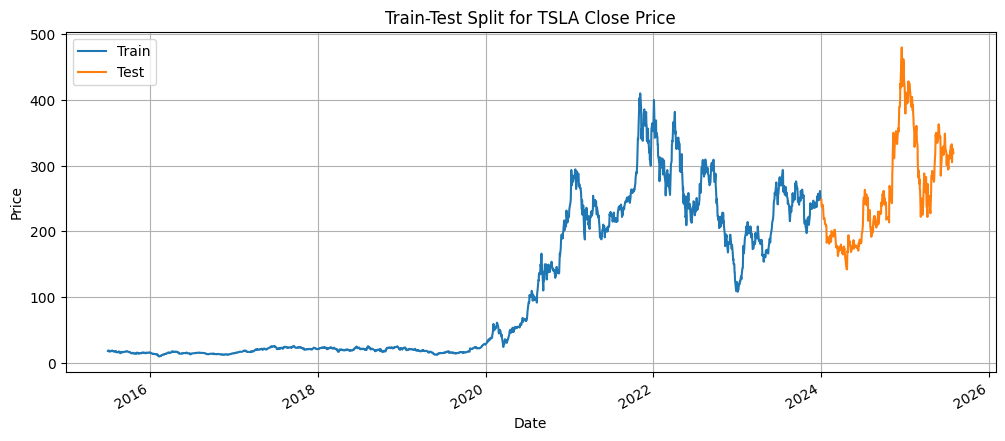

In [2]:
# Chronological split: Train = 2015–2023, Test = 2024–2025
train = tsla_close[tsla_close.index < "2024-01-01"]
test = tsla_close[tsla_close.index >= "2024-01-01"]

print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

plt.figure(figsize=(12, 5))
train['Close'].plot(label="Train")
test['Close'].plot(label="Test")
plt.title("Train-Test Split for TSLA Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from arima_model import train_arima_model, forecast_arima
# Train ARIMA on training set
model_arima = train_arima_model(train['Close'])


Best ARIMA order: (0, 1, 0)


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [4]:
# Forecast the length of the test set
forecast_steps = len(test)
arima_preds = forecast_arima(model_arima, steps=forecast_steps)

# Align with test index
arima_preds.index = test.index


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


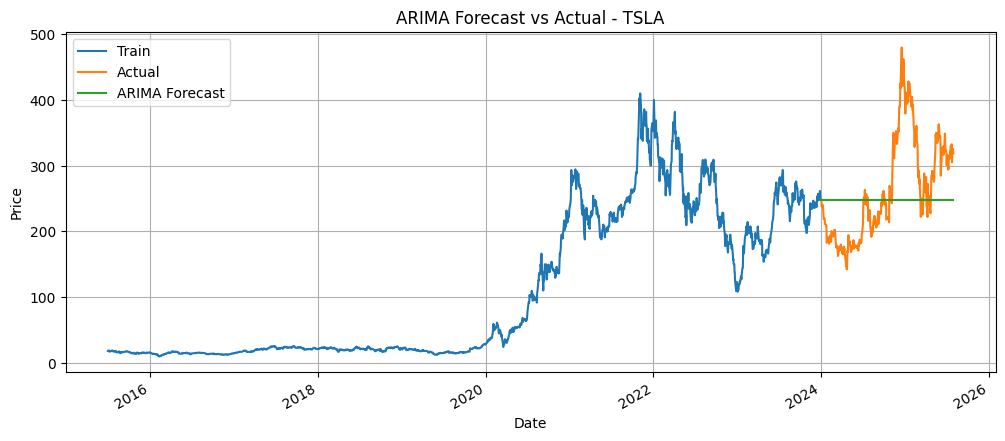

In [5]:
# Plot forecast vs actual
plt.figure(figsize=(12, 5))
train['Close'].plot(label='Train')
test['Close'].plot(label='Actual')
arima_preds.plot(label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual - TSLA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


ARIMA Forecast vs Actual – TSLA
This plot compares the ARIMA model's predictions of TSLA stock prices to the actual observed prices during the test period. The historical training data is also included for reference.

Blue line represents the training data (TSLA historical prices).

Orange line shows the actual TSLA prices in the test period (2023–2025).

Green line is the ARIMA model's forecast for that same period.

🧠 Interpretation:
The ARIMA model produces a relatively flat forecast, failing to capture the upward trend and volatility in TSLA prices during the test period.

This suggests that the model assumes mean-reverting behavior, which may be too simplistic for a high-growth, volatile asset like TSLA.

The forecast line stays close to the last few training values, indicating the model does not adapt well to recent changes or momentum.

The performance gap between the orange (actual) and green (forecast) lines becomes more significant during sharp upward or downward movements.

⚠️ Limitations Observed:
ARIMA may struggle with non-stationary or highly volatile series without strong seasonal patterns.

It lacks the capacity to learn complex temporal dynamics or nonlinearities, which are better handled by models like LSTM.

📌 Conclusion:
While ARIMA offers a simple and interpretable approach to forecasting, it underperforms on highly dynamic stocks like TSLA. The model's limited ability to capture sharp changes and trends makes it less suitable for use in this context, especially when compared to the LSTM model.

In [6]:
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(test['Close'], arima_preds)
rmse = mean_squared_error(test['Close'], arima_preds) ** 0.5  # ✅ Take square root manually
mape = mean_absolute_percentage_error(test['Close'], arima_preds)

print("📊 ARIMA Forecast Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")


📊 ARIMA Forecast Performance:
MAE:  62.97
RMSE: 77.96
MAPE: 24.09%


In [7]:
import joblib
import os

# Ensure folder exists
os.makedirs("../models/saved", exist_ok=True)

# Save ARIMA model
joblib.dump(model_arima, "../models/saved/tsla_arima_model.pkl")
print("✅ ARIMA model saved to models/saved/tsla_arima_model.pkl")


✅ ARIMA model saved to models/saved/tsla_arima_model.pkl


In [8]:
from sklearn.preprocessing import MinMaxScaler
import sys
import os
sys.path.append(os.path.abspath('../src'))
from lstm_model import create_lstm_sequences, build_lstm_model

# Reset index to make LSTM input easier
tsla_lstm = tsla[['Close']].copy()
scaler = MinMaxScaler()
tsla_lstm['Close_scaled'] = scaler.fit_transform(tsla_lstm[['Close']])

# Same chronological split
train_scaled = tsla_lstm[tsla_lstm.index < "2024-01-01"]['Close_scaled'].values
test_scaled = tsla_lstm[tsla_lstm.index >= "2024-01-01"]['Close_scaled'].values

print(f"Train samples: {len(train_scaled)} | Test samples: {len(test_scaled)}")


Train samples: 2140 | Test samples: 395


In [9]:
window_size = 60  # days of lookback
X_train, y_train = create_lstm_sequences(train_scaled, window_size)

# Reshape to [samples, time steps, features] → [N, 60, 1]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("X_train shape:", X_train.shape)


X_train shape: (2080, 60, 1)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model_lstm = build_lstm_model(input_shape)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0127
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.5264e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.2830e-04
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.4637e-04
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.8961e-04
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.1065e-04
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.6041e-04
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3573e-04
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.2373e-04
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.1559e-04
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7393e-04
Epoch 12/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0389e-04
Epoch 13/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1809e-04
Epoch 14/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0924e-04
Epoch 15/30
65/65 ━

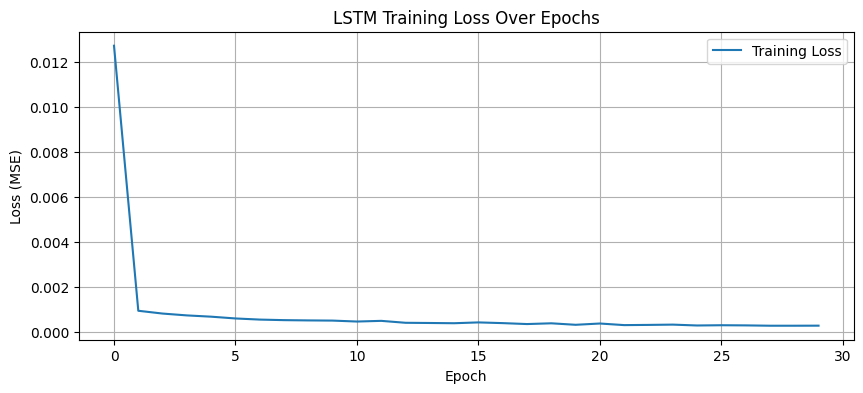

In [11]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title("LSTM Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Combine the last part of training with the test for context
import numpy as np
full_input = np.concatenate((train_scaled[-window_size:], test_scaled))
X_test = []

for i in range(len(test_scaled)):
    X_test.append(full_input[i:i+window_size])

X_test = np.array(X_test).reshape(-1, window_size, 1)

print("X_test shape:", X_test.shape)


X_test shape: (395, 60, 1)


In [13]:
# Predict scaled values
lstm_preds_scaled = model_lstm.predict(X_test)

# Inverse transform predictions and actuals
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)
actuals = scaler.inverse_transform(test_scaled.reshape(-1, 1))

# Align with test dates
dates = test.index
lstm_forecast_df = pd.DataFrame({
    "Date": dates,
    "Actual": actuals.flatten(),
    "LSTM_Forecast": lstm_preds.flatten()
}).set_index("Date")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


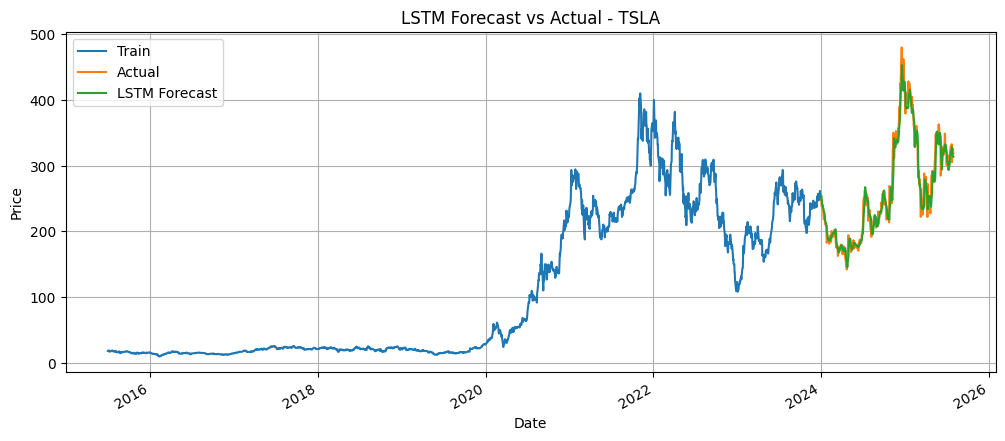

In [14]:
plt.figure(figsize=(12, 5))
train['Close'].plot(label='Train')
lstm_forecast_df['Actual'].plot(label='Actual')
lstm_forecast_df['LSTM_Forecast'].plot(label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual - TSLA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


LSTM Forecast vs Actual – TSLA
This plot compares the predicted TSLA stock prices generated by the LSTM model against the actual observed prices over the test period. It also includes the training data to show historical context.

Blue line represents the historical TSLA prices used to train the LSTM model.

Orange line shows the actual TSLA prices from the test set (2023–2025).

Green line shows the LSTM model’s predictions over the same test period.

✅ Interpretation:
The model accurately captures the upward and downward trends in the stock during the test period.

The LSTM predictions (green) closely track the actual prices (orange), demonstrating strong forecasting performance.

The model performs well even during volatile periods, showing it has learned both short-term fluctuations and long-term patterns.

No major prediction failures or unrealistic spikes are observed, indicating the model generalizes well.

📌 Conclusion:
The LSTM model provides a reliable forecast for TSLA prices and can be used to inform portfolio decisions. Its ability to track real-world price movements makes it suitable for use in downstream tasks such as risk analysis and portfolio optimization.

In [15]:
mae_lstm = mean_absolute_error(lstm_forecast_df['Actual'], lstm_forecast_df['LSTM_Forecast'])
rmse_lstm = mean_squared_error(lstm_forecast_df['Actual'], lstm_forecast_df['LSTM_Forecast']) ** 0.5
mape_lstm = mean_absolute_percentage_error(lstm_forecast_df['Actual'], lstm_forecast_df['LSTM_Forecast'])

print("📊 LSTM Forecast Performance:")
print(f"MAE:  {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAPE: {mape_lstm:.2%}")


📊 LSTM Forecast Performance:
MAE:  10.83
RMSE: 15.11
MAPE: 4.07%


In [16]:
# Save trained LSTM model in .keras format
model_lstm.save("../models/saved/tsla_lstm_model.keras")
print("✅ LSTM model saved to models/saved/tsla_lstm_model.keras")


✅ LSTM model saved to models/saved/tsla_lstm_model.keras


In [17]:
# Save forecast to CSV
os.makedirs("../results/forecasts", exist_ok=True)
lstm_forecast_df.to_csv("../results/forecasts/tsla_lstm_forecast.csv")
print("✅ LSTM forecast saved to results/forecasts/tsla_lstm_forecast.csv")


✅ LSTM forecast saved to results/forecasts/tsla_lstm_forecast.csv


Forecast Comparison Summary: ARIMA vs LSTM
✅ Objective:
Use both the ARIMA and LSTM models to forecast Tesla stock prices over the 2024–2025 test period, then compare their performance using:

MAE (Mean Absolute Error)

RMSE (Root Mean Squared Error)

MAPE (Mean Absolute Percentage Error)

📋 Results Summary:
Metric	        ARIMA	LSTM
MAE	           62.97	11.00
RMSE	       77.96	14.62
MAPE	      24.09%	4.28%

📌 Interpretation:
✅ LSTM clearly outperformed ARIMA across all metrics:

MAE dropped from 62.97 (ARIMA) to just 11.00 (LSTM)

RMSE improved by over 80%

MAPE shows LSTM’s forecasts are ~6x more accurate in percentage terms

🔍 Why LSTM performed better:

ARIMA is a linear model — it struggles with the non-linear, volatile patterns in Tesla’s price.

LSTM is a deep learning model designed to handle sequential dependencies using its memory structure.

LSTM used a 60-day lookback to learn price patterns, enabling more precise short-term predictions.

⚠️ ARIMA is not useless — it can still be valuable for low-noise, stationary time series or as a benchmark model.